# Evaluation

In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import pickle
import os
import anndata as ad
import seaborn as sns
from src import utils
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
from scipy.linalg import lstsq
import random
import matplotlib as mpl

utils.plot_style()
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)
os.makedirs('plots/', exist_ok=True)

In [2]:
n_cells_full = 25
n_cells_hold_out = 20

In [3]:
data = pd.read_feather('../../data/application/data_preprocessed.feather')

# select genes with an average of more than 30 counts per cell
gene_count = (data.groupby(['gene']).size().to_frame('count')
    .sort_values(by='count').reset_index())
filtered_genes = (gene_count.query('count > ({} * 30)'
    .format(data.cell.unique().shape[0])).gene.values)
data = data[data.gene.isin(filtered_genes)]

In [4]:
data_full = data[data.cell<n_cells_full].copy()

data_full['cell_id'], _ = pd.factorize(data_full['cell'])
data_full['gene_id'], _ = pd.factorize(data_full['gene'])
data_full = utils.rescale_cells(data_full)

results_full = pickle.load(open('results/full/final/latents.pkl', 'rb'))
z_full = results_full['z']
z_full = torch.nan_to_num(z_full, 0)
z_full /= z_full.flatten(start_dim=2).max(dim=-1)[0].view(n_cells_full, z_full.shape[1], 1, 1)

w_full = results_full['w']
w_full /= w_full.max(dim=0)[0].view(1, w_full.shape[1])

In [5]:
data_hold_out = data[data.cell<n_cells_hold_out].copy()

data_hold_out['cell_id'], _ = pd.factorize(data_hold_out['cell'])
data_hold_out['gene_id'], _ = pd.factorize(data_hold_out['gene'])
data_hold_out = utils.rescale_cells(data_hold_out)

results_hold_out = pickle.load(open('results/hold_out/final/latents.pkl', 'rb'))
z_hold_out = results_hold_out['z']
z_hold_out = torch.nan_to_num(z_hold_out, 0)
z_hold_out /= z_hold_out.flatten(start_dim=2).max(dim=-1)[0].view(n_cells_hold_out, z_hold_out.shape[1], 1, 1)

w_hold_out = results_hold_out['w']
w_hold_out /= w_hold_out.max(dim=0)[0].view(1, w_hold_out.shape[1])

In [6]:
inds, _ = utils.optimal_assignment(z_full[:n_cells_hold_out], z_hold_out, 1)

w_hold_out = w_hold_out[:, inds]
z_hold_out = z_hold_out[:, inds]

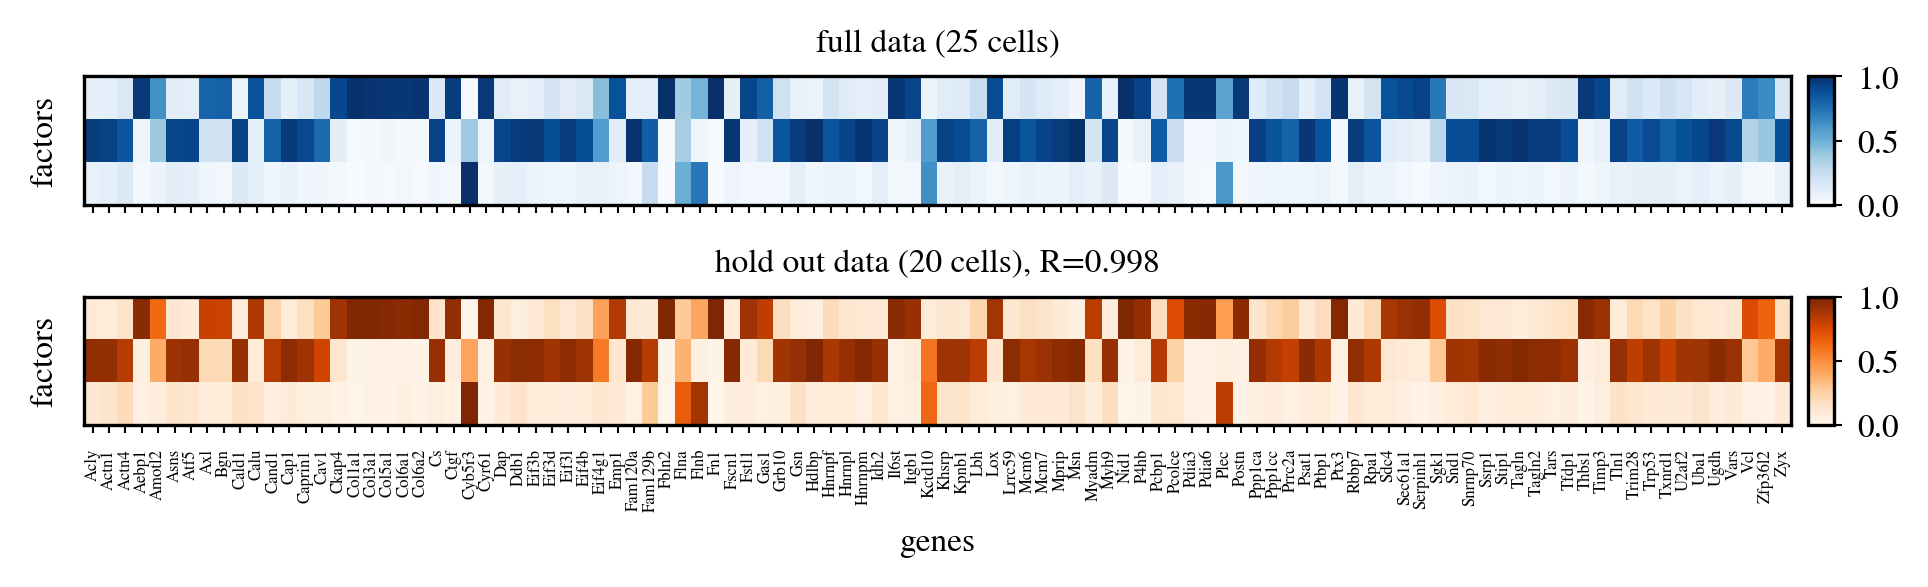

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(6.5, 2), dpi=300)

im = axs[0].matshow(w_full.T, cmap='Blues', aspect='auto')
axs[0].set_xticks(np.arange(w_hold_out.shape[0]))
axs[0].set_xticklabels([])
axs[0].xaxis.set_ticks_position('bottom')
axs[0].set_yticks([])
axs[0].set_ylabel('factors')
axs[0].set_title('full data ({} cells)'.format(n_cells_full))
cbar = plt.colorbar(im, ax=axs[0], aspect=5, pad=0.01, fraction=0.02)
cbar.ax.set_yticks([0., 0.5, 1.])

im = axs[1].matshow(w_hold_out.T, aspect='auto', cmap='Oranges')
axs[1].set_xticks(np.arange(w_hold_out.shape[0]))
axs[1].set_xticklabels(np.sort(data_hold_out.gene.unique()), rotation='vertical', fontsize=4)
axs[1].xaxis.set_ticks_position('bottom')
axs[1].set_ylabel('factors')
axs[1].set_xlabel('genes')
axs[1].set_yticks([])
axs[1].set_title('hold out data ({} cells), R={}'.format(n_cells_hold_out, round(pearsonr(w_hold_out.flatten(), w_full.flatten())[0], 3)))
cbar = plt.colorbar(im, ax=axs[1], aspect=5, pad=0.01, fraction=0.02)
cbar.ax.set_yticks([0., 0.5, 1.])

plt.tight_layout()
plt.savefig('plots/weights.svg')

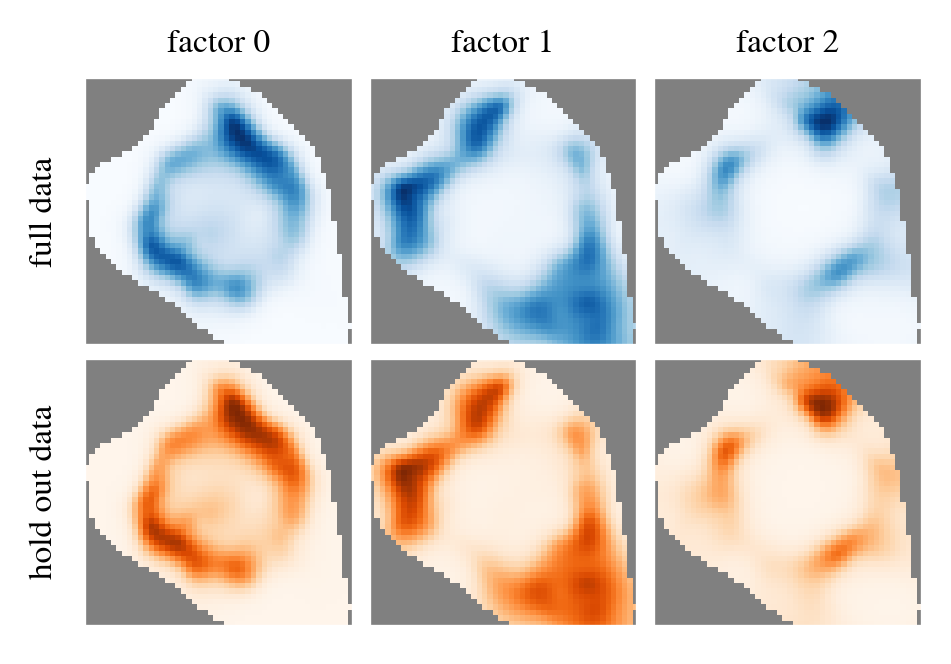

In [8]:
cell = 16
fig, axs = plt.subplots(2, 3, figsize=(3,  2), dpi=300)

cmap1 = mpl.cm.get_cmap('Blues').copy()
cmap1.set_under(color='grey')
cmap2 = mpl.cm.get_cmap('Oranges').copy()
cmap2.set_under(color='grey')

for factor in range(3):
    axs[0, factor].matshow(z_full[cell, factor], origin='lower', cmap=cmap1, vmin=1e-6)
    axs[1, factor].matshow(z_hold_out[cell, factor], origin='lower', cmap=cmap2, vmin=1e-6)
    axs[0, factor].set_title('factor {}'.format(factor))

axs[0, 0].set_ylabel('full data')
axs[1, 0].set_ylabel('hold out data')

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor('white')

plt.tight_layout(pad=0.01)
plt.savefig('plots/factors_both_cell_{}.svg'.format(cell))

In [14]:
# density estimation based on molecule coordinates
grid = utils.grid(50)
genes = np.sort(data_full.gene.unique())
intensity_estimate = torch.zeros([n_cells_full, len(genes), 50, 50])

for cell in range(n_cells_full):
    cell_data = data_full.query('cell=={}'.format(cell))
    for j, gene in enumerate(genes):
        gene_data = cell_data.query('gene=="{}"'.format(gene))
        if gene_data.shape[0] <= 2:
            continue

        kde = gaussian_kde(gene_data[['x', 'y']].to_numpy().T)
        intensity_estimate[cell, j] = torch.tensor(kde(grid.T).reshape(50, 50))

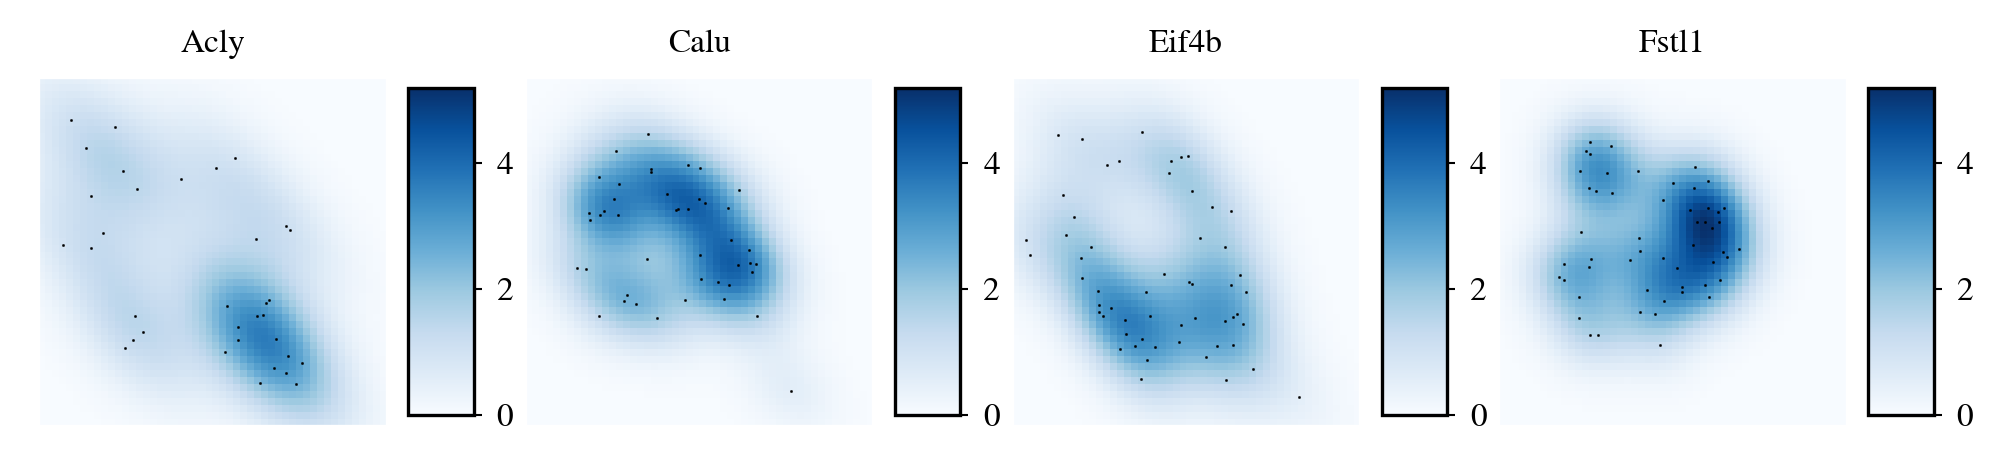

In [20]:
cell = 24
gene_ids = [0, 10, 30, 40]

fig, axs = plt.subplots(1, len(gene_ids), figsize=(6.5, 3), dpi=300)

cell_data = data_full.query('cell=={}'.format(cell))

for j, gene_id in enumerate(gene_ids):
    gene = genes[gene_id]
    gene_data = cell_data.query('gene=="{}"'.format(gene))
    im = axs[j].matshow(intensity_estimate[cell, gene_id], origin='lower', cmap='Blues', vmin=intensity_estimate[cell, gene_ids].min(), vmax=intensity_estimate[cell, gene_ids].max())
    axs[j].scatter(gene_data.x * 50 - 0.5, gene_data.y * 50 - 0.5, s=0.3, linewidth=0.1, c='black')
    axs[j].set_title(gene)
    cbar = plt.colorbar(im, ax=axs[j], aspect=5)

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor('white')

plt.tight_layout(pad=0.1)
plt.savefig('plots/densities.svg')

In [12]:
projections = torch.zeros([n_cells_full, 3, 50, 50])

for cell in range(n_cells_full):
    projections[cell] = torch.tensor(lstsq(w_hold_out, intensity_estimate[cell].flatten(start_dim=1))[0].reshape(-1, 50, 50))

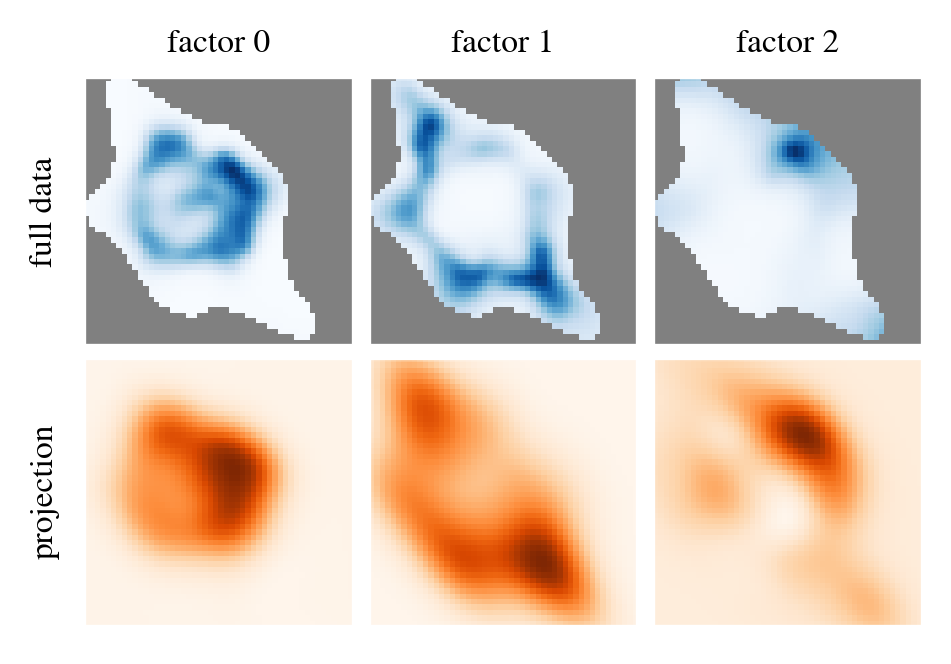

In [13]:
cell = 24
fig, axs = plt.subplots(2, 3, figsize=(3,  2), dpi=300)

cmap1 = mpl.cm.get_cmap('Blues').copy()
cmap1.set_under(color='grey')
cmap2 = mpl.cm.get_cmap('Oranges').copy()
cmap2.set_under(color='grey')

for factor in range(3):
    axs[0, factor].matshow(z_full[cell, factor], origin='lower', cmap=cmap1, vmin=1e-6)
    axs[1, factor].matshow(projections[cell, factor], origin='lower', cmap=cmap2)
    axs[0, factor].set_title('factor {}'.format(factor))

axs[0, 0].set_ylabel('full data')
axs[1, 0].set_ylabel('projection')

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor('white')

plt.tight_layout(pad=0.01)
plt.savefig('plots/projection_cell_{}.svg'.format(cell))

In [14]:
print(pearsonr(z_full[n_cells_hold_out:].flatten(), projections[n_cells_hold_out:].flatten()))

PearsonRResult(statistic=0.7246862134053613, pvalue=0.0)
